<a href="https://colab.research.google.com/github/neel-machine/News-recommendation-system/blob/main/news_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd


In [3]:
con_data = pd.read_csv('drive/My Drive/consumer_transanctions.csv')
con_data.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [4]:
con_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


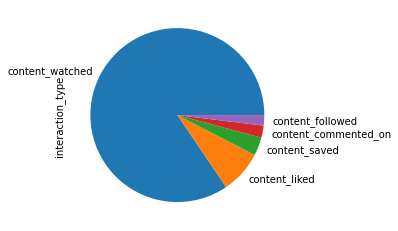

In [5]:
con_data.interaction_type.value_counts().plot(kind = 'pie')

In [6]:
con_data.consumer_location.nunique()

71

Consumer location unique value indicates that users from 71 different cities are using this application. Lets see the top 10 locations

In [7]:
con_data.consumer_location.value_counts()[:10]

SP    40164
MG    10229
NY     1257
TX      923
GA      910
RJ      775
NJ      698
?       327
CA      238
ON      202
Name: consumer_location, dtype: int64

In [8]:
con_data.country.value_counts()

BR    51396
US     4657
KR      239
CA      226
JP      144
AU      138
GB       22
DE       19
IE       14
IS       13
ZZ       11
SG       11
AR        7
PT        6
ES        3
IN        3
MY        2
IT        2
CN        1
NL        1
CL        1
CO        1
CH        1
Name: country, dtype: int64

country details indicate that majority of hits come from USA and Brazil. They both constitute 77.5 % of total hits

In [9]:
len(con_data[(con_data.country == 'US' )] + con_data[(con_data.country == 'BR' )])/con_data.shape[0] * 100

77.51548843898661

In [10]:
con_data.shape[0]


72312

Lets remove rest of the columns from the dataset and only keep item_id,consumer_id and interaction type. We will generate ratings from interaction type column which will become an important feature for this recommendation system.

In [11]:
con_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


In [12]:
con_data = con_data[["interaction_type","consumer_id","item_id"]]

In [13]:
con_data.head()

,interaction_type,consumer_id,item_id
0,content_watched,-8845298781299428018,-3499919498720038879
1,content_watched,-1032019229384696495,8890720798209849691
2,content_watched,-1130272294246983140,310515487419366995
3,content_followed,344280948527967603,310515487419366995
4,content_watched,-445337111692715325,-7820640624231356730


In [14]:
con_data.interaction_type.value_counts()

content_watched         61086
content_liked            5745
content_saved            2463
content_commented_on     1611
content_followed         1407
Name: interaction_type, dtype: int64

In [15]:
interactions = con_data.interaction_type.value_counts()*100/con_data.shape[0]

In [16]:
engagement_df = pd.DataFrame(interactions)

In [17]:
engagement_df

,interaction_type
content_watched,84.475606
content_liked,7.944739
content_saved,3.406074
content_commented_on,2.227846
content_followed,1.945735


In [18]:
engagement_df.reset_index(inplace=True)

In [19]:
engagement_df

,index,interaction_type
0,content_watched,84.475606
1,content_liked,7.944739
2,content_saved,3.406074
3,content_commented_on,2.227846
4,content_followed,1.945735


In [20]:
engagement_df.columns = ["interaction_type","value"]

In [21]:
engagement_df

,interaction_type,value
0,content_watched,84.475606
1,content_liked,7.944739
2,content_saved,3.406074
3,content_commented_on,2.227846
4,content_followed,1.945735


Lets impute rating value into the dataset. Lets assign ratings from 1 to 5 , 5 being the highest. content_liked should have highest rating because a customer has liked something, followed by content_followed, content_saved,content_watched and content_comented_on.

In [22]:
engagement_df['ratings'] = 100/engagement_df.value

In [23]:
engagement_df

,interaction_type,value,ratings
0,content_watched,84.475606,1.183774
1,content_liked,7.944739,12.586945
2,content_saved,3.406074,29.359318
3,content_commented_on,2.227846,44.886406
4,content_followed,1.945735,51.394456


In [24]:
con_data_mod = pd.merge(con_data,engagement_df,on='interaction_type')

In [34]:
con_data_mod.sample(20)

,interaction_type,consumer_id,item_id,value,ratings
31657,content_watched,6013226412048763966,8224860111193157980,84.475606,1.183774
24156,content_watched,-1443636648652872475,-8167536150098135304,84.475606,1.183774
34598,content_watched,-1479311724257856983,7526364197140419661,84.475606,1.183774
4716,content_watched,3938645257702379823,-5507019982244746725,84.475606,1.183774
35600,content_watched,-1380636509010496168,-1573329182923097618,84.475606,1.183774
40589,content_watched,7774613525190730745,-2584174137395076448,84.475606,1.183774
15865,content_watched,-709287718034731589,7943088471380012839,84.475606,1.183774
70049,content_liked,-3203894957285229214,-1878128207048892154,7.944739,12.586945
14530,content_watched,-647801535221797956,2080544143997420913,84.475606,1.183774
53543,content_watched,-1393866732742189886,7334805502505837712,84.475606,1.183774


In [36]:
con_data_mod.drop(['interaction_type','value'],axis = 1,inplace=True)

In [38]:
con_data_mod.drop_duplicates(inplace=True)

In [39]:
con_data_mod.shape

(50938, 3)

In [42]:
con_data.consumer_id.nunique()

1895

We have merged two dataframes and now we also removed duplicates leaving us with 50938 rows. Since we have negative values in consumer_id column, and it will be a problem when we want to cream user matrix we will map these ids to column have rows from 0 to 1895

In [43]:
con_data_mod['news_id'] = con_data_mod.groupby(['item_id']).ngroup()

In [44]:
con_data_mod.head()

,consumer_id,item_id,ratings,news_id
0,-8845298781299428018,-3499919498720038879,1.183774,933
1,-1032019229384696495,8890720798209849691,1.183774,2933
2,-1130272294246983140,310515487419366995,1.183774,1537
3,-445337111692715325,-7820640624231356730,1.183774,246
4,-8763398617720485024,310515487419366995,1.183774,1537


In [45]:
con_data_mod['user_id'] = con_data_mod.groupby(['consumer_id']).ngroup()

In [49]:
con_data_mod.sample(30)

,consumer_id,item_id,ratings,news_id,user_id
39596,-7898880382889684604,-435798809553722526,1.183774,1412,139
68375,4548917054177353037,-6783772548752091658,12.586945,406,1418
70767,-7487897518634781969,-1453783314552286835,44.886406,1241,175
18230,-453678802103139441,6309804346176212907,1.183774,2511,885
35804,-5713424050095083786,-4844663695104994694,1.183774,724,346
53920,7048619884024295715,231281690254211527,1.183774,1529,1664
27052,-1130272294246983140,3799414975499163376,1.183774,2099,826
36110,7780048623954214635,-5065077552540450930,1.183774,687,1738
24198,-2626634673110551643,2203293143157288172,1.183774,1817,682
64992,-1292787032977259947,511891900317865118,12.586945,1573,815


In [50]:
ratings = con_data_mod[["ratings","news_id","user_id"]]

In [51]:
ratings.head()

,ratings,news_id,user_id
0,1.183774,933,33
1,1.183774,2933,831
2,1.183774,1537,826
3,1.183774,246,887
4,1.183774,1537,42


In [53]:
ratings.news_id.nunique()

2987

In [54]:
ratings.user_id.nunique()

1895